## Adiabatic parameters from neutron's paths
Emma Klemets   
Nov. 2022   
Full documentation of the theory can be found at: https://www.overleaf.com/read/rfkkhhwwfjct

Looking at adiabatic transport from the side of the physical parameters, mainly the magnetic field.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from scipy import ndimage
from numpy import linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib.colors as mpl_colors
import matplotlib as mpl

from stl import mesh
from mpl_toolkits import mplot3d

In [2]:
import sys, os
sys.path.insert(1, '../MesonMagMapping/PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
import AdiabaticEquations as Adi
%load_ext autoreload
%autoreload 2

In [3]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

[11-10 8:41 a.m.] Jeffery W. Martin
Also, just to set a scale for this problem:

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the UCN moves in a straight line at 8 m/s.

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the magnetic field rotates by 90 degrees during this time.

[11-10 8:43 a.m.] Jeffery W. Martin
Actually, let's say it rotates by 90 degrees in the course of 1 m of travel by the neutron.

[11-10 8:43 a.m.] Jeffery W. Martin
And let's say the value of the field is typically 1 mT.

[11-10 8:43 a.m.] Jeffery W. Martin
For this situation, I get k=15,000



In [4]:
#trying out Jeff's numbers, matches up
v_vec = np.array([8, 0, 0]) #m/s

B_1 = np.array([1, 0, 0])*1e-6 #=1uT
B_2 = np.array([0, 1, 0])*1e-6 #=1uT
r_1 = np.array([0, 0, 0]) 
r_2 = np.array([1, 0, 0]) #dx = 1m

Adi.K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

14.582346536127906

In [5]:
#scalar imputs for simplicity
#speed of your neutrons
vn = 8 #/ms
#magnitude of your magnetic field
B = 500*1e-6 #T
#distance travels during the turn
dx = .2 #m

#calculates the k value for a 90 degrees turn with a uniform magnitude magnetic field (B)
#for a given neutron speed (vn) and distance of the turn (dx) 
Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)

1458.234653612791

In [6]:
#addes labels to contour lines nicely
def fmt_lable(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"$k$ = {s}" if plt.rcParams["text.usetex"] else f"$k$ = {s}"

#returns the index of the closest value to N in a list generated 
#from the unique values in a given column of a df
def FindClosest(df, N, val):
    dfun = df[val].unique()
    # print(len(dfun))
    difference_array = np.absolute(dfun-N)
    index = difference_array.argmin()
    return index

In [7]:
#widget inline

"""
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""
def rangeOfdx_forK(B_arr, dx_arr, Vmin=None, Vmax=None):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dx in dx_arr:
            val = Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)
            k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dx','k'])
    df = df.pivot("B", "dx", "k")

    df = df.reindex(index=df.index[::-1])
    # print(k_array)

    fig, ax = plt.subplots(figsize=(6, 5))
    if isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(), linewidths=0)
    else:
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax)
    
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=10)

    ax.collections[0].colorbar.set_label("k")
    # ax.set_yscale("log")
    

   # format text labels
    fmt = '{:0.1f}' #dx
    i = 0
    xticklabels = []
    for item in ax.get_xticklabels():
        # print(item.get_text())
        item.set_text(fmt.format(float(item.get_text())*1e6/100))
        if i%2==0:#removes every other tick label
            xticklabels += [item]
        else:
            xticklabels += [""]

        i+=1

    fmt = '{:0.1f}'
    #B
    yticklabels = []
    j=0
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())*1e6))
        if j%2==0:#removes every other tick label
            yticklabels += [item]
        else:
            yticklabels += [""]
        j+=1

    ax.set_yticklabels(yticklabels)
    ax.set_xticklabels(xticklabels)#,  rotation=0)
    ax.set_xlabel("$\Delta x$ [cm]")
    ax.set_ylabel("B [$\mu$T]")

    ax.set_title("$k$ value for a $90^\circ$ turn in $\Delta x$ distance at a"+
                 " \n given a constant B field and $v = 8$ m/s")#, size=20)
    fig.tight_layout()
    
"""
Same as above, but with custom axis tick labels
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""   
def rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None, R_G=False):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dx in dx_arr:
            val = Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)
            k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dx','k'])
    df["B"] = df["B"]*1e6 #convert to uT
    df["dx"] = df["dx"]*100 #convert to cm
    
    yticklabels_set = [1, 10, 100, 250, 500]
    # the index position of the tick labels
    yticks = []    
    for label in yticklabels_set:
        idx_pos = FindClosest(df, label, "B")
        yticks.append(len(df["B"].unique())-idx_pos)
           
    xticklabels_set = [.1, 10, 20, 30]
    # the index position of the tick labels
    xticks = []    
    for label in xticklabels_set:
        idx_pos = FindClosest(df, label, "dx")
        xticks.append(idx_pos)
    
    df = df.pivot("B", "dx", "k")
    df = df.reindex(index=df.index[::-1])
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    if R_G:
        #https://matplotlib.org/stable/gallery/color/custom_cmap.html
        colors = [(0, (0.94118, 0.25882, 0.25882)), (1, (0.23137, 0.67059, 0.23137))]  # R -> G
        n_bin = 2
        cmap_name = 'my_list'
        
        bounds = [0, 30, 45]
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        q = sns.heatmap(df, cmap=cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N), linewidths=0)
        # ax.collections[0].colorbar.set_ticklabels(['nonadiabatic','k = 30','adiabatic'])
        
    elif isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(), linewidths=0)        
    else:
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax)#, yticklabels=yticklabels_set)
        
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=12)

    # ax.collections[0].colorbar.set_label("k")

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels_set)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels_set)#,  rotation=0)
    ax.set_xlabel("Arc length ($\Delta x$) [cm]")
    ax.set_ylabel("Magnetic field (B) [$\mu$T]")

    # ax.set_title("$k$ value for a $90^\circ$ turn in $\Delta x$ distance at a"+
    #              " \n given a constant B field and $v = 8$ m/s")#, size=20)
    fig.tight_layout()
    return ax

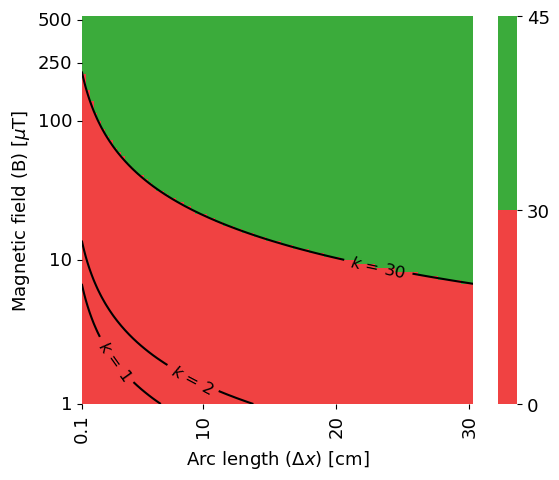

In [8]:
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams.update({'font.size': 13})
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)

B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
dx_arr = np.linspace(.01, .30, n)

ax = rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None, R_G=True)
# ax.title("")
# colorEarth = 'g'
# ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
# ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )
# #hmm the spand doesn't match up with my axis ticks
plt.tight_layout()

plt.savefig('Photos/dx_vs_B_klines_redGreen.png', transparent=True)
plt.show()

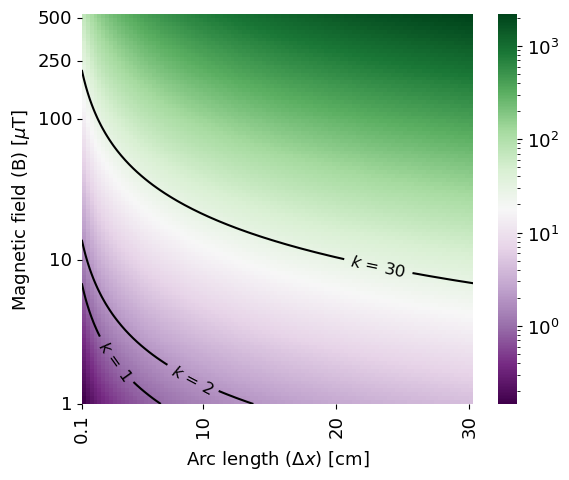

In [9]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)

B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
dx_arr = np.linspace(.01, .30, n)

rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None)

plt.savefig('Photos/dx_vs_B_klines.png', transparent=True)
plt.show()

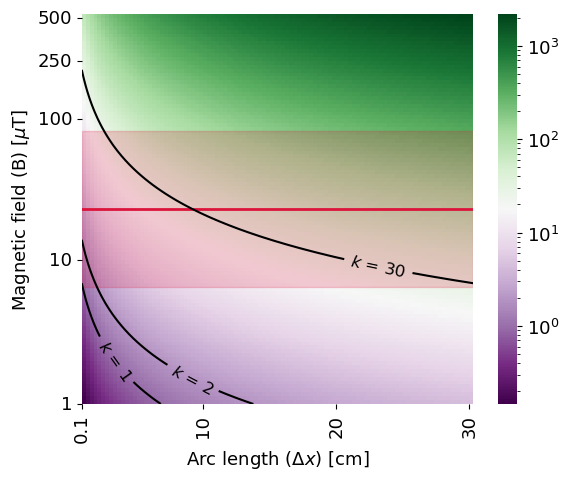

In [10]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)

B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
dx_arr = np.linspace(.01, .30, n)

ax = rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None)
colorEarth = 'crimson'
ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )
#hmm the spand doesn't match up with my axis ticks
plt.tight_layout()

plt.savefig('Photos/dx_vs_B_klines_earth.png', transparent=True)
plt.show()

In [11]:
#now the same thing as above, but not in terms of a rotation, just the B field and 
#the change of the B field
"""
B_arr - array of B values to plot [T]
dbdx_arr - array of dB/dx value to plot [T/m]

"""
def rangeOfdxdb_forK(B_arr, dbdx_arr, Vmin=None, Vmax=None):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dbdx in dbdx_arr:
            val = Adi.K_equ_dbdx(B, dbdx, vn)
            k_array = np.append(k_array, np.array([[B, dbdx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dbdx','k'])
    df = df.pivot("B", "dbdx", "k")

    df = df.reindex(index=df.index[::-1])
    # print(k_array)

    fig, ax = plt.subplots(figsize=(6, 5))
    if isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(), linewidths=0)
    else:
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax)
    
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=10)

    ax.collections[0].colorbar.set_label("k")
    # ax.set_yscale("log")
    

   # format text labels
    fmt = '{:0.1f}' #dx
    i = 0
    xticklabels = []
    for item in ax.get_xticklabels():
        # print(item.get_text())
        item.set_text(fmt.format(float(item.get_text())*1e6/100))
        if i%2==0:#removes every other tick label
            xticklabels += [item]
        else:
            xticklabels += [""]

        i+=1

    fmt = '{:0.1f}'
    #B
    yticklabels = []
    j=0
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())*1e6))
        if j%2==0:#removes every other tick label
            yticklabels += [item]
        else:
            yticklabels += [""]
        j+=1

    ax.set_yticklabels(yticklabels)
    ax.set_xticklabels(xticklabels)#,  rotation=0)
    ax.set_xlabel("$\\frac{dB}{dx}$ [$\mu$T/cm]")
    ax.set_ylabel("B [$\mu$T]")

    ax.set_title("$k$ value for different combinations of B and \n$\Delta$B values for $v = 8$ m/s")#, size=20)

    fig.tight_layout()

def rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=None, Vmax=None, R_G=False):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dbdx in dbdx_arr:
            val = Adi.K_equ_dbdx(B, dbdx, vn)
            k_array = np.append(k_array, np.array([[B, dbdx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dbdx','k'])
    df["B"] = df["B"]*1e6 #convert to uT
    df["dbdx"] = df["dbdx"]*1e6/100 #convert to uT/cm
    
    yticklabels_set = np.array([1, 10, 100, 250, 500]) #/100
    # the index position of the tick labels
    yticks = []    
    for label in yticklabels_set:
        idx_pos = FindClosest(df, label, "B")
        yticks.append(len(df["B"].unique())-idx_pos)
           
    xticklabels_set = np.array([.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) #/100
    # the index position of the tick labels
    xticks = []    
    for label in xticklabels_set:
        idx_pos = FindClosest(df, label, "dbdx")
        xticks.append(idx_pos)
    
    df = df.pivot("B", "dbdx", "k")
    df = df.reindex(index=df.index[::-1])
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    if R_G:
        #https://matplotlib.org/stable/gallery/color/custom_cmap.html
        colors = [(0, (0.94118, 0.25882, 0.25882)), (1, (0.23137, 0.67059, 0.23137))]  # R -> G
        n_bin = 2
        cmap_name = 'my_list'
        
        bounds = [0, 2, 45]
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        q = sns.heatmap(df, cmap=cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N), linewidths=0)
        # ax.collections[0].colorbar.set_ticklabels(['nonadiabatic','k = 2','adiabatic'])
        
    elif isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(), linewidths=0)
    else:
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax)#, yticklabels=yticklabels_set)
        
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=12)

    ax.collections[0].colorbar.set_label("k")

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels_set)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels_set)#,  rotation=0)
    ax.set_xlabel("Change of magnetic field $\\left( \\frac{dB}{dx} \\right) $ [$\mu$T/cm]")
    ax.set_ylabel("Magnetic field (B) [$\mu$T]")

    # ax.set_title("$k$ value for different combinations of B and \n$\Delta$B values for $v = 8$ m/s")#, size=20)

    fig.tight_layout()
    return ax

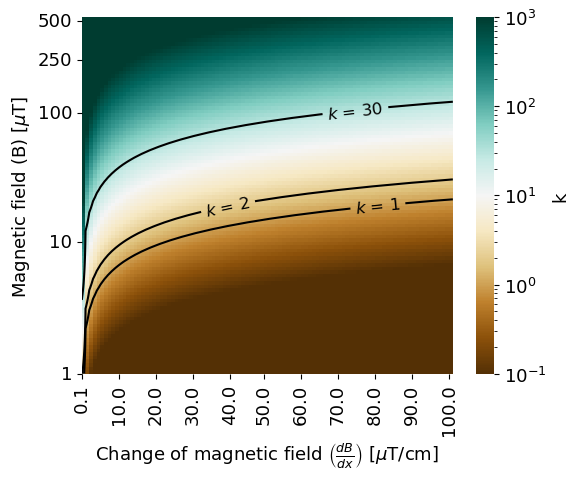

In [12]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)

dbdx_arr = np.linspace(1e-5, 0.01, n) #T/m

rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=0.1, Vmax=1000)

plt.savefig('Photos/dB_vs_B_klines.png', transparent=True)
plt.show()

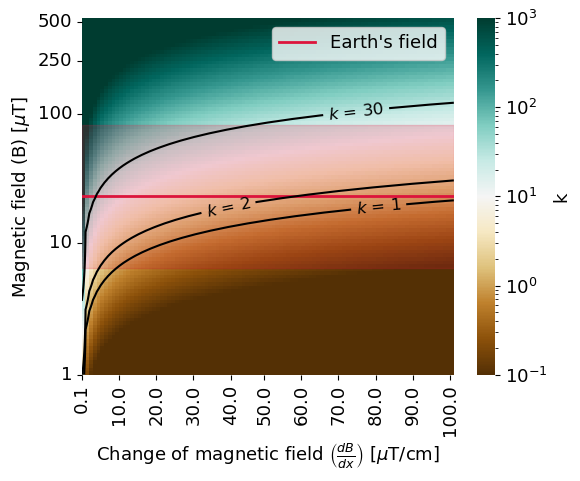

In [13]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
plt.rcParams.update({'font.size': 13})

dbdx_arr = np.linspace(1e-5, 0.01, n) #T/m

ax = rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=0.1, Vmax=1000)

colorEarth = 'crimson'
ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )

plt.legend()
plt.tight_layout()

plt.savefig('Photos/dB_vs_B_klines_earth.png', transparent=True)
plt.show()

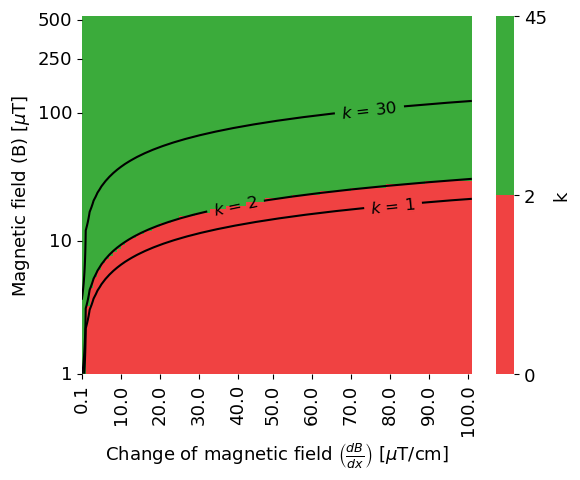

In [14]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)

dbdx_arr = np.linspace(1e-5, 0.01, n) #T/m

ax = rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=0.1, Vmax=1000, R_G=True)

# colorEarth = 'g'
# ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
# ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )

plt.tight_layout()
plt.savefig('Photos/dB_vs_B_klines_redGreen.png', transparent=True)
plt.show()

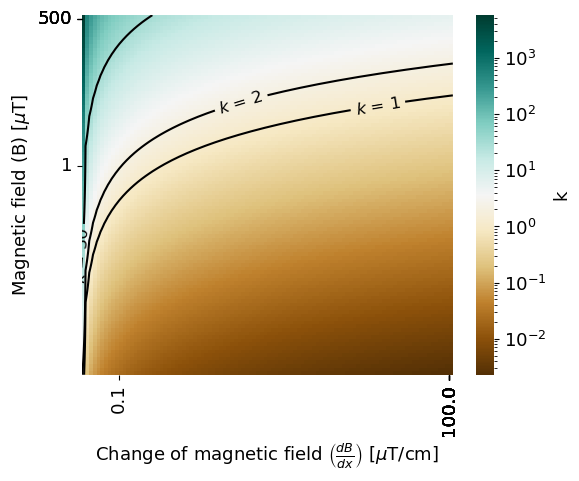

In [15]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(.1e-6), np.log10(5e-6), num=n, base=10.0)

dbdx_arr = np.linspace(1e-7, 0.0001, n) #T/m

rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr)#, Vmin=0.01, Vmax=100)

plt.show()

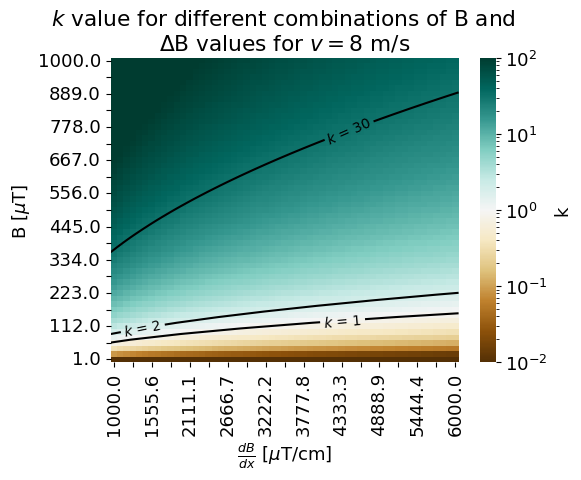

In [16]:
n = 55
B_arr = np.linspace(1e-6, 1000e-6, n) #T
dbdx_arr = np.linspace(.1, .6, n) #T/m

rangeOfdxdb_forK(B_arr, dbdx_arr, Vmin=0.01, Vmax=100)
plt.show()

# An idea of the B field
We have a lot of different regions, with different things that will affect the field:
 * SCM - well mapped
 * SSA - ?
 * Sheilding blocks - very much going to change
 * AMC - still in development, 
 * Background cylotron field - dipole analytic model
 * etc
 
 We need to start simpler than this.
 
 <img src="./Photos/guidingFieldDiagram.jpg" width="700" />

## Analytic Dipole model

The background field from the cylotron has been previously modeled usin an analytic dipole model for the potential, $\Phi_{dipole}$ and then using $\vec{B} = -\nabla \Phi_{dipole}$ to get the resulting magnetic field.

From the TUCAN 2022 status report: 12.1.3 Recent progress
Refined FEA simulation of the background magnetic field and compensating fields.

> The cyclotron stray field was approximated by a dipole field originated at (x, y) ≈ (−16m,−11m) away
from the center of the MSR and implemented to the FEA simulation.
- this is done with the center of the MSR as the origin
- only reproduces the major features of the field well for z > 0, and around the MSR

In [17]:
from sympy.vector import CoordSys3D, gradient

In [18]:
"""
Using the dipole model for the potential, calculates the B field for a given
region of points
Input:
    x_input, y_input, z_input: 1D arrays of points for each dimension of the region
Output:
    B_dipole: pd data frame with columes: ['x', 'y', 'z', 'B_x', 'B_y', 'B_z', 'B']
    - distances are in m, field is in T
"""
def DipoleField(x_input, y_input, z_input):
    #define a coordinate system to use
    R = CoordSys3D('F_{MSR}') 
    M = sp.symbols("M_v")
    x0,y0, z0 = sp.symbols(" x_0  y_0 z_0")
    x,y, z = sp.symbols(" x  y z")

    #the dipole function for the scalar potential
    Phi = sp.Function("\Phi_{dipole}")(M, R.x, x0,R.y, y0,R.z, z0 )
    Phi_funct = -M*(R.z-z0) / ((R.x-x0)**2 + (R.y-y0)**2 +(R.z-z0)**2)**(3/2)

    # The fit parameters from Takashi's work
    M_fit = -1.577 #T·m^3
    x0_fit = -16.03 #m
    y0_fit = -10.52 #m
    z0_fit = 0.531 #m 

    Phi_funct = Phi_funct.subs(M, M_fit).subs(x0, x0_fit).subs(y0, 
                            y0_fit).subs(z0, z0_fit) 

    # Phi_funct
    B = sp.Function("\\vec{B}_{dipole}")(R.x, R.y, R.z)
    #take the -gradient of the scalar potential
    B_funct = -1*gradient(Phi_funct).simplify()
    # display(sp.Eq(B, B_funct, evaluate=False))
    B_funct = B_funct.to_matrix(R)
    
    #convert each component back to a normal function to evalute numerically
    f_x = B_funct[0].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_x = sp.lambdify((x, y, z), f_x)

    f_y = B_funct[1].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_y = sp.lambdify((x, y, z), f_y)

    f_z = B_funct[2].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_z = sp.lambdify((x, y, z), f_z)
    
    # get a meshgrid of the region we actually want data for (in meters)
    xx, yy, zz = np.meshgrid(x_input, y_input, z_input, copy=True)

    #get the B field component in each position
    B_Xeval = B_x(xx, yy, zz)
    B_Yeval = B_y(xx, yy, zz)
    B_Zeval = B_z(xx, yy, zz)

    NT = np.product(xx.shape)
    # print(NT)

    #convert into a pandas data frame for use
    data = { #coords in m, B in T
        "x": np.reshape(xx,NT),
        "y": np.reshape(yy,NT),
        "z": np.reshape(zz,NT), 
        "B_x": np.reshape(B_Xeval,NT), 
        "B_y": np.reshape(B_Yeval,NT), 
        "B_z": np.reshape(B_Zeval,NT), 
        "B": np.reshape(np.sqrt(B_Xeval**2 + B_Yeval**2 + B_Zeval**2),NT), 
    }

    B_dipole = pd.DataFrame(data=data)
    return B_dipole

In [19]:
# get a meshgrid of the region we actually want data for (in meters)
n = 20
DimX = np.linspace(-1, 1, n)
DimY = np.linspace(-2, 0, n)
DimZ = np.linspace(-0.6, 0.6, n)

#and use the analytic model to get the field for the given points
B_dipole = DipoleField(DimX, DimY, DimZ)
B_dipole.columns

Index(['x', 'y', 'z', 'B_x', 'B_y', 'B_z', 'B'], dtype='object')

## 2019 and 2022 base mapping data

In [20]:
#importing data from my 2022 fall mapping
colNames = ['x', 'y', 'z', 'B_x', 'B_y', 'B_z']
#uses cm and uT already
file_22 = "../MesonMagMapping/Fall_2022/data_export/map_referencedMSR_fall2022_together_interp50.txt"
data_myMapping2022_base = pd.read_csv(file_22, comment='#', sep='\t', names=colNames)
#cutting the data to only the region no more than 80 cm below the center of the MSR

file_22_s = "../MesonMagMapping/Fall_2022/data_export/map_referencedMSR_fall2022_stairs_interp50.txt"
data_myMapping2022_stairs = pd.read_csv(file_22_s, comment='#', sep='\t', names=colNames)

data_myMapping2022 = pd.concat([data_myMapping2022_base, data_myMapping2022_stairs])
data_myMapping2022 = data_myMapping2022[data_myMapping2022.z > -80]

data_myMapping2022["B"] = np.sqrt(data_myMapping2022.B_x**2 + data_myMapping2022.B_y**2 + data_myMapping2022.B_z**2)

#and the data from 2019, as it covers bigger region
file_19 = "../MesonMagMapping/MagMapping-export_TH_2019/data_export/map_referencedMSR_interp50.txt"
data_Mapping2019 = pd.read_csv(file_19, comment='#', sep='\t', names=colNames)

data_Mapping2019 = data_Mapping2019[data_Mapping2019.z > -80]
data_Mapping2019 = data_Mapping2019[data_Mapping2019.y < 0]

data_Mapping2019["B"] = np.sqrt(data_Mapping2019.B_x**2 + data_Mapping2019.B_y**2 + data_Mapping2019.B_z**2)

## SCM

In [21]:
def rotateBData(df_data, origin, angle):
    data_pos = rotate3D(df_data[['x', 'y', 'z']].values, origin=origin, degrees=angle)
    
    #gotta check this part makes sense
    data_B = rotate3D(df_data[['B_x', 'B_y', 'B_z']].values, origin=origin, degrees=angle)
    print(f"Rotation of {angle} degrees")
    
    df_data_rot = pd.DataFrame(data_pos, columns=['x', 'y', 'z'])
    df_data_rot[['B_x', 'B_y', 'B_z']] = data_B
    
    return df_data_rot

def rotate3D(p, origin=(0, 0, 0), degrees=0):
    #3D rotation
    angle = np.deg2rad(degrees)
    
    R = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle),  np.cos(angle), 0],
                  [0, 0, 1]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    A = np.squeeze((R @ (p.T-o.T) + o.T).T)
    return A


In [22]:
os.listdir('referenceMaps/tucan-magnetics-SCM-mapping-main/SCM_mapping_20191120/')

filePath_SCM_T = 'referenceMaps/tucan-magnetics-SCM-mapping-main/'

In [23]:
df0 = pd.read_csv(f'{filePath_SCM_T}SCM_mapping_20191120/20191120_1406_RUN1_200A_center_avg_corr.csv', 
                 names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])
df1 = pd.read_csv(f'{filePath_SCM_T}SCM_mapping_20191120/20191120_1422_RUN2_100A_center_avg_corr.csv',
                 names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])
df2 = pd.read_csv(f'{filePath_SCM_T}SCM_mapping_20191120/20191120_1447_RUN3_200A_dZ_-25mm__avg_corr.csv',
                 names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])


df3 = pd.read_csv('./referenceMaps/tucan-magnetics-SCM-mapping-main/SCM_mapping_20191126/20191126_1345_200A_center_w_yoke_avg.csv',
        names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])

# df3

In [24]:
df_all = pd.concat([df0, df2, df3])

#flip sign of Y
df_all.Y = -df_all.Y 
df_all.B_Y = -df_all.B_Y

#switch X and z coods
Xsave = df_all.X
BXsave = df_all.B_X

df_all.X = df_all.Z
df_all.B_X = df_all.B_Z

df_all.Z = Xsave
df_all.B_Z = BXsave

# df_all
df_all_TSCM = df_all.rename({'X': 'x', 'Y': 'y', 'Z': 'z', 
                        'B_X': 'B_x', 'B_Y': 'B_y', 'B_Z': 'B_z'}, axis=1)

df_all_TSCM["B"] = np.sqrt(df_all_TSCM.B_x**2 + df_all_TSCM.B_y**2 + df_all_TSCM.B_z**2)

df02_X = df_all[df_all.Z==0]
df02_Z = df_all[df_all.X==0]

xz_0 = np.unique(df0[['X', 'Z']], axis=0)
xz_2 = np.unique(df2[['X', 'Z']], axis=0)
Xs = np.unique(df02_X['X'], axis=0)
Zs = np.unique(df02_Z['Z'], axis=0)
Ys = np.unique(df_all['Y'], axis=0)

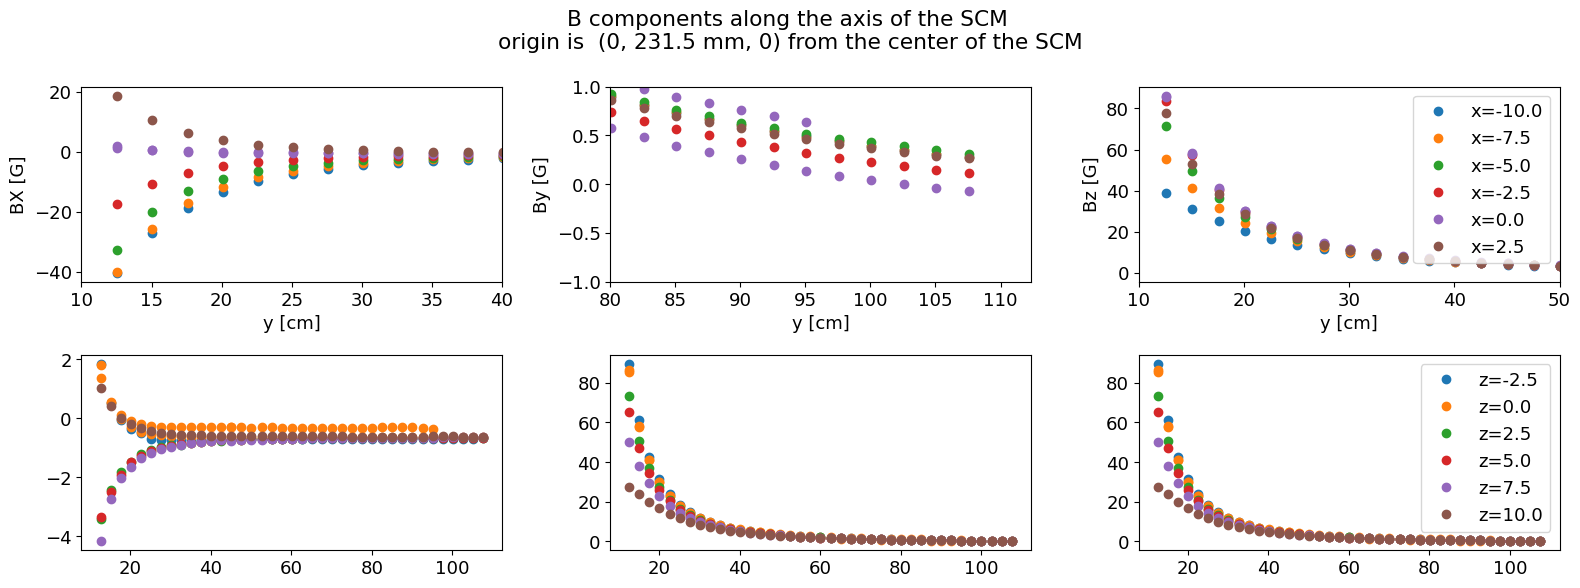

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(16,6))

axs =axs.flatten()

for Zi in Xs:
    axs[0].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_X'], 'o', label='x=%.1f' %Zi, lw=.8)#,markersize=1)
    axs[1].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_Y'], 'o', label='x=%.1f' %Zi, lw=.8)#,markersize=1)
    axs[2].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_Y'], 'o', label='x=%.1f' %Zi ,lw=.8)#,markersize=1)

for Zi in Zs:
    axs[3].plot(df02_Z[df02_Z['Z']==Zi]['Y'], df02_Z[df02_Z['Z']==Zi]['B_X'], 'o', label='z=%.1f' %Zi, lw=.8)#,markersize=1)
    axs[4].plot(df02_Z[df02_Z['Z']==Zi]['Y'], df02_Z[df02_Z['Z']==Zi]['B_Y'], 'o', label='z=%.1f' %Zi, lw=.8)#,markersize=1)
    axs[5].plot(df02_Z[df02_Z['Z']==Zi]['Y'], df02_Z[df02_Z['Z']==Zi]['B_Y'], 'o', label='z=%.1f' %Zi ,lw=.8)#,markersize=1)

axs[0].set_ylabel('BX [G]')
axs[0].set_xlabel('y [cm]')
axs[0].set_xlim(10, 40)

# axs[1].plot(df_all.Y, df_all.B_Y, ls="", marker="o")
axs[1].set_ylabel('By [G]')
axs[1].set_xlabel('y [cm]')
axs[1].set_xlim(80)
axs[1].set_ylim(-1, 1)

# axs[2].plot(df_all.Y, df_all.B_Z, ls="", marker="o")
axs[2].set_ylabel('Bz [G]')
axs[2].set_xlabel('y [cm]')

axs[2].set_xlim(10, 50)

plt.suptitle("B components along the axis of the SCM \norigin is  (0, 231.5 mm, 0) "+ 
             "from the center of the SCM")
plt.tight_layout()
axs[2].legend()
axs[5].legend()
plt.show()

In [26]:
def T_SCM_2019_ToMSR(Data):
    # display(Data)
    Data_Copy = Data.copy()
    #first shift to match the PENTrack origin
    Data_Copy.y += 23.15 #cm
    
    df_data = rotateBData(Data_Copy, np.zeros(3), 20)
    
    # Rotate -110 deg about z axis, 
    # The move X=+0.223, Y = -6.489 m
    x_off = +22.3 # cm 
    y_off = - 648.9 # cm 
    
    df_data.x +=x_off
    df_data.y +=y_off
    
    #convert from G to T
    
    df_data.B_x = df_data.B_x*1e-4
    df_data.B_y = df_data.B_y*1e-4
    df_data.B_z = df_data.B_z*1e-4   
    df_data["B"] = np.sqrt(df_data.B_x**2 + df_data.B_y**2 + df_data.B_z**2)
    
    return df_data

In [27]:
SCM_T2019_MSR = T_SCM_2019_ToMSR(df_all_TSCM)
# SCM_T2019_MSR

Rotation of 20 degrees


# All the data together

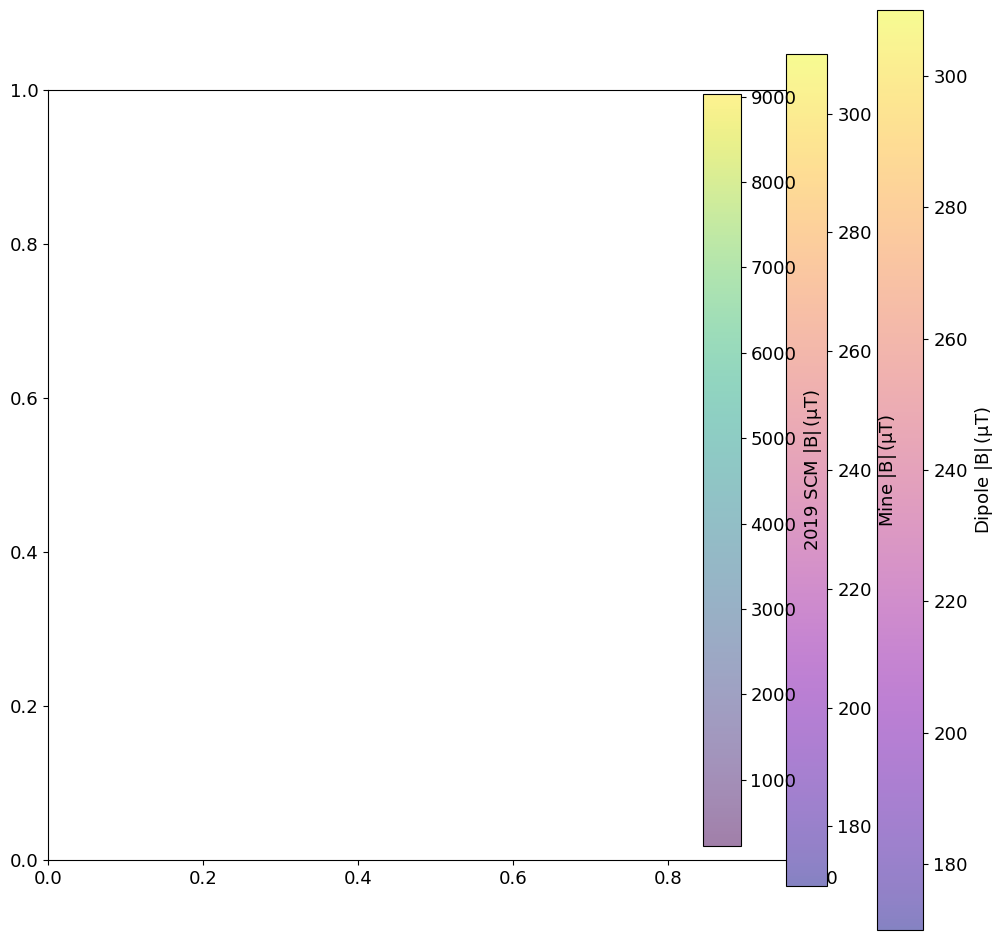

In [28]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# plt.title("2019 Magnetic field mapping", pad=-10)

Q_dipole = axes.scatter(B_dipole['x'], B_dipole['y'], B_dipole['z'],
                            c=B_dipole['B']*1e6, s=1, alpha=0.5, cmap='plasma', label="Dipole field", 
                       vmin=170, vmax=310)

cbar = fig.colorbar(Q_dipole, label='Dipole $\mathsf{|B|\,(\mu T)}$', fraction=0.046)#, cax=cax)

Q_myMapping = axes.scatter(data_myMapping2022['x']/100, data_myMapping2022['y']/100, 
                           data_myMapping2022['z']/100, c=data_myMapping2022['B'], s=1, 
                           alpha=0.5, cmap='plasma', label="My mapped field", 
                           vmin=170, vmax=310)

cbar = fig.colorbar(Q_myMapping, label='Mine $\mathsf{|B|\,(\mu T)}$', fraction=0.046)#, cax=cax)
     
Q_myMapping = axes.scatter(SCM_T2019_MSR['x']/100, SCM_T2019_MSR['y']/100, 
                           SCM_T2019_MSR['z']/100, c=SCM_T2019_MSR['B']*1e6, s=1, 
                           alpha=0.5, cmap='viridis', label="Takashi 2019 SCM mapping") 

cbar = fig.colorbar(Q_myMapping, label='2019 SCM $\mathsf{|B|\,(\mu T)}$', fraction=0.046)#, cax=cax)

axes.scatter(0, 0, 0, marker="*", s=100, color="orange", label="MSR origin")
axes.scatter(0.223, -6.489, 0, marker="*", s=100, color="red", 
             label="PENTrack origin")
     
#loads all the file I have in this folder as STLs
STLpath = '../MesonMagMapping/PrettyPlotTools/STLsToGraph_F_MSR'
stl_array = np.array(os.listdir(STLpath))

# to cut out some unness stls
mask = np.ones(len(stl_array))
mask[[2,3,6,7,9,11,12]] = 0
mask = np.array(mask, dtype='bool')
stl_array = stl_array[mask]

for STLfile in stl_array:
    ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
# axes.view_init(elev=10., azim=45)
axes.view_init(elev=90., azim=-90) #top view
axes.set_xlim(-2, 2)
axes.set_ylim(-8, 1)
axes.set_zlim(-0.6, 0.6)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

In [29]:
# SCM_T2019_MSR[['x']]
SCM_T2019_MSR_2 = SCM_T2019_MSR.copy()
SCM_T2019_MSR_2[['x','y','z']] = SCM_T2019_MSR[['x','y','z']].apply(lambda x: x/100)

# SCM_T2019_MSR_2

In [30]:
## Look at B vs positions 'along' the guides

colors = ['royalblue', 'coral', 'purple', 'darkgreen', 'brown']

def plotAll(component, axis, background=False):
    
    cutX = [-0.5, 0.5]
    cutZ = [-0.5, 0.5]
    
    #dipole data in m and T
    B_dipole_cut = B_dipole[(B_dipole['x'] < cutX[1]) & (B_dipole['x'] > cutX[0]) & 
                           (B_dipole['z'] < cutZ[1]) & (B_dipole['z'] > cutZ[0])]
    
    #my 2022 data in cm and uT
    myMapping_cut = data_myMapping2022[(data_myMapping2022['x']/100 < cutX[1]) & 
                                      (data_myMapping2022['x']/100 > cutX[0]) & 
                       (data_myMapping2022['z']/100 < cutZ[1]) & (data_myMapping2022['z']/100 > cutZ[0])]
    
    #scm 2019 data in cm and T
    SCM_T2019_cut = SCM_T2019_MSR[(SCM_T2019_MSR['x']/100 < cutX[1]) & (SCM_T2019_MSR['x']/100 > cutX[0]) & 
                   (SCM_T2019_MSR['z']/100 < cutZ[1]) & (SCM_T2019_MSR['z']/100 > cutZ[0])]
   
    data_Mapping2019_cut = data_Mapping2019[(data_Mapping2019['x']/100 < cutX[1]) & 
                                  (data_Mapping2019['x']/100 > cutX[0]) & 
                   (data_Mapping2019['z']/100 < cutZ[1]) & (data_Mapping2019['z']/100 > cutZ[0])]
    
    if not background:
        axis.plot(B_dipole_cut['y'], B_dipole_cut[component]*1e6, ls="", marker="o", 
                  color=colors[0], alpha=0.4, label="Analytic dipole model of the Cyclotron field")
        axis.plot(data_Mapping2019_cut['y']/100, data_Mapping2019_cut[component], 
              ls="", marker="o", color=colors[4], alpha=0.2, label="Summer 2019 mapping")  
        axis.plot(myMapping_cut['y']/100, myMapping_cut[component], 
              ls="", marker="o", color=colors[1], alpha=0.4, label="Fall 2022 mapping")  
        axis.plot(SCM_T2019_cut['y']/100, SCM_T2019_cut[component]*1e6, ls="", 
                  marker="o", color=colors[2], alpha=0.4, label="2019 SCM stray field mapping")
    else:
        backColor= 'grey'
        axis.plot(B_dipole_cut['y'], B_dipole_cut[component]*1e6, ls="", marker="o", 
          color=backColor, alpha=0.2, label="Data used")
        axis.plot(data_Mapping2019_cut['y']/100, data_Mapping2019_cut[component], 
              ls="", marker="o", color=backColor, alpha=0.2)  
        axis.plot(myMapping_cut['y']/100, myMapping_cut[component], 
              ls="", marker="o", color=backColor, alpha=0.2)  
        axis.plot(SCM_T2019_cut['y']/100, SCM_T2019_cut[component]*1e6, ls="", 
                  marker="o", color=backColor, alpha=0.2)
    
    return

In [31]:
#I'm not really sure how far is okay to use the dipole model, but like it's better than nothing
n = 20
split = - 3.2 #m - really approx. placement of the split to 2 guides - should check

DimX = np.linspace(-0.5, 0.5, n)
DimY = np.linspace(split, 0, n)
DimZ = np.linspace(-0.5, 0.5, n)

#and use the analytic model to get the field for the given points
B_dipole_split = DipoleFeild(DimX, DimY, DimZ)

DimX = np.linspace(-0.2, 0.2, n)
DimY = np.linspace(-5.5, split, n)
DimZ = np.linspace(-0.2, 0.2, n)

B_dipole_single = DipoleFeild(DimX, DimY, DimZ)

B_dipole = pd.concat([B_dipole_split, B_dipole_single])


NameError: name 'DipoleFeild' is not defined

In [ ]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18,8))

ax0= fig.add_subplot(2,3,1)
ax1= fig.add_subplot(2,3,2)
ax2= fig.add_subplot(2,3,3)
ax3= fig.add_subplot(2,1,2)

axs = [ax0, ax1, ax2, ax3]

plt.suptitle("B field from different models/data-set for a region of x, z in ~ [-0.5, 0.5] m "+ 
             "approximately along the guides")

plotAll('B_x', axs[0])

axs[0].set_ylabel('B$_x$ [$\mu$T]')
axs[0].set_xlabel('Y [m]')
# axs[0].axhline(0, ls=":", c="black")
axs[0].set_yscale('symlog', linthresh=0.2)
# axs[0].set_ylim(-100, 25)
axs[0].invert_xaxis()

plotAll('B_y', axs[1])
axs[1].set_ylabel('B$_y$ [$\mu$T]')
axs[1].set_xlabel('Y [m]')
axs[1].axhline(0, ls=":", c="black", label='Zero field')
axs[1].set_yscale("symlog", linthresh=0.2)
# axs[1].set_ylim(-60, 10)
axs[1].invert_xaxis()

plotAll('B_z', axs[2])
axs[2].set_ylabel('B$_z$ [$\mu$T]')
axs[2].set_xlabel('Y [m]')
axs[2].axhline(0, ls=":", c="black")
# axs[2].set_yscale("symlog")
axs[2].set_ylim(-400, 0)
axs[2].invert_xaxis()

plotAll('B', axs[3])
axs[3].set_ylabel('B [$\mu$T]')
axs[3].set_xlabel('Y [m]')
# axs[3].axhline(0, ls=":", c="black")
axs[3].set_yscale("symlog", linthresh=0.2)
# axs[3].set_ylim(-100, 25)
axs[3].invert_xaxis()

leg = axs[3].legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
plt.tight_layout()
plt.show()

 <img src="./Photos/guidingFieldDiagram_withLengths.jpg" width="750" />

Clearly $B_z$ should be expected to be much greater than the other two components for any regions unaffected by more local magnetic source (the only one seen here is the SCM).

Now how can I use this very approximate map to get k values? I really need some sort of idea of the gradient as well to calculate k.

In [ ]:
# data_myMapping2022

"""
To do any sort of averages, as the points don't all line up, i should do a bit of binning 
before to group them up.
- how will i weight the different values?
    - just like how far from the center of the guide the value is ?
"""

bend20 = -5
split = -3.2
splitEnd = -3.2 + 0.5

def guideSingle(y):
    #pre 20 degrees bend?
    if y < bend20: 
        #get the line between the bend
        x_ = [0, +0.223]
        y_ = [bend20, -6.489]

        linFit = np.polyfit(y_, x_, 1)
        x = linFit[0]*y + linFit[1]
        z = 0
    else:
    # post bend
        x = 0 #m
        z = 0 #m
        
    return x, z
    
def guideUpper(y):
    #pre 20 degrees bend?
    if y < splitEnd: 
        #get the line between the bend
        x_ = [0, -.65/2]
        y_ = [split, splitEnd]
        z_ = [0,  .67/2 ]

        linFitX = np.polyfit(y_, x_, 1)
        linFitZ = np.polyfit(y_, z_, 1)
        
        x = linFitX[0]*y + linFitX[1]
        z = linFitZ[0]*y + linFitZ[1]
    else:
    # post split
        x = -.65/2 #m
        z = .67/2 #m
        
    return x, z
    
def guideLower(y):
    #pre 20 degrees bend?
    if y < splitEnd: 
        #get the line between the bend
        x_ = [0, .65/2]
        y_ = [split, splitEnd]
        z_ = [0,  -.67/2 ]

        linFitX = np.polyfit(y_, x_, 1)
        linFitZ = np.polyfit(y_, z_, 1)
        
        x = linFitX[0]*y + linFitX[1]
        z = linFitZ[0]*y + linFitZ[1]
    else:
    # post split
        x = .65/2 #m
        z = -.67/2 #m
        
    return x, z

def compareToGuides(y, Up=True):
    if y < split: #single guide
        x, z = guideSingle(y)
    elif Up: #split guides
        x, z = guideUpper(y)
    else:
        x, z = guideLower(y)
        
    return x, z
        
guideSingle = np.vectorize(guideSingle, otypes=[float, float])
guideUpper = np.vectorize(guideUpper, otypes=[float, float])
guideLower = np.vectorize(guideLower, otypes=[float, float])
compareToGuides = np.vectorize(compareToGuides, otypes=[float, float])

In [ ]:
y_arr = np.linspace(-6.4, 0)
outarr = np.array(compareToGuides(y_arr))
GuidesUp = np.insert(outarr, 1, y_arr, axis=0)

outarr = np.array(compareToGuides(y_arr, Up=False))
GuidesDown = np.insert(outarr, 1, y_arr, axis=0)


# fig = plt.figure(figsize=(10,3))
# ax0= fig.add_subplot(1,2,1)
# ax1= fig.add_subplot(1,2,2)
# ax0.plot(y_arr, outarr[0])
# ax0.set_ylabel("x [m]")
# ax1.plot(y_arr, outarr[1])
# ax1.set_ylabel("z [m]")
# plt.show()

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

axes.plot(GuidesUp[0], GuidesUp[1], GuidesUp[2], label="Upper guide")
axes.plot(GuidesDown[0], GuidesDown[1], GuidesDown[2], label="Lower guide")


axes.scatter(0, 0, 0, marker="*", s=100, color="orange", label="MSR origin")
axes.scatter(0.223, -6.489, 0, marker="*", s=100, color="red", 
             label="PENTrack origin")

#loads all the file I have in this folder as STLs
STLpath = '../MesonMagMapping/PrettyPlotTools/STLsToGraph_F_MSR'
stl_array = os.listdir(STLpath)
stl_array = np.array(os.listdir(STLpath))

# to cut out some unness stls
mask = np.ones(len(stl_array))
mask[[2,3,6,7,9,11,12]] = 0
mask = np.array(mask, dtype='bool')
stl_array = stl_array[mask]

for STLfile in stl_array:
    ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
axes.view_init(elev=10., azim=45)
# axes.view_init(elev=90., azim=-90) #top view
axes.set_xlim(-2, 2)
axes.set_ylim(-8, 1)
axes.set_zlim(-0.6, 0.6)
    
axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

In [ ]:
"""
Make all the data in [m] and [uT] and concatonate it all into on df
"""
def AllData():
    
    #make all df in m and T
    
    myMapping_fixed = data_myMapping2022.copy()
    myMapping_fixed[['x','y','z']] = myMapping_fixed[['x','y','z']].apply(lambda x: x/100)
    myMapping_fixed[['B_x','B_y','B_z', 'B']] = myMapping_fixed[['B_x','B_y',
                                                'B_z', 'B']].apply(lambda x: x*1e-6)
    
    Mapping2019_fixed = data_Mapping2019.copy()
    Mapping2019_fixed[['x','y','z']] = Mapping2019_fixed[['x','y','z']].apply(lambda x: x/100)
    Mapping2019_fixed[['B_x','B_y','B_z', 'B']] = Mapping2019_fixed[['B_x','B_y',
                                            'B_z', 'B']].apply(lambda x: x*1e-6)

    SCM_T2019_MSR_fixed = SCM_T2019_MSR.copy()
    SCM_T2019_MSR_fixed[['x','y','z']] = SCM_T2019_MSR_fixed[['x','y','z']].apply(lambda x: x/100)
    # SCM_T2019_MSR_fixed[['B_x','B_y','B_z', 'B']] = SCM_T2019_MSR_fixed[['B_x','B_y',
    #                                                 'B_z', 'B']].apply(lambda x: x*1e6)
  
    B_dipole_fixed = B_dipole.copy()
    # B_dipole_fixed[['B_x','B_y','B_z', 'B']] = B_dipole_fixed[['B_x','B_y',
    #                                                 'B_z', 'B']].apply(lambda x: x*1e6)
    
    df_allData = pd.concat([myMapping_fixed, Mapping2019_fixed, SCM_T2019_MSR_fixed, B_dipole_fixed])
    
    return df_allData

df_allData = AllData()

#cutting the data so we are looking only around the guides roughly
cutX = [-0.5, 0.5]
cutZ = [-0.5, 0.5]
    
#dipole data in m and T
df_allData = df_allData[(df_allData['x'] < cutX[1]) & (df_allData['x'] > cutX[0]) & 
                       (df_allData['z'] < cutZ[1]) & (df_allData['z'] > cutZ[0])]

In [ ]:
def weightMean(data_row, guideFunct):
    x0, z0 = guideFunct(data_row.y)
    
    #weight by the closeness to the guide center: 1/r
    weight = 1 / np.sqrt((data_row.x - x0)**2 + (data_row.z - z0)**2)
    
    return weight
    

In [ ]:
weights = df_allData.apply(weightMean, axis=1, guideFunct=compareToGuides)


In [ ]:
df_allData["W"] = weights

In [ ]:
def MeanW(data):
    # print(data)
    # print(data['y'].unique())
    meanX = np.sum(data.B_x*data.W)
    meanY = np.sum(data.B_y*data.W)
    meanZ = np.sum(data.B_z*data.W)
    meanB = np.sum(data.B*data.W)
    
    weightSum= np.sum(data.W)
    
    return [meanX, meanY, meanZ, meanB]/weightSum

# df_means = df_allData[['y', 'B_x','B_y','B_z', 'B', "W"] ]

Y_s = df_allData['y'].unique()

df_means = pd.DataFrame(columns=['y', 'B_x', 'B_y','B_z', 'B'] )
df_maxs = pd.DataFrame(columns=['y', 'B_x', 'B_y','B_z', 'B'] )
df_mins = pd.DataFrame(columns=['y', 'B_x', 'B_y','B_z', 'B'] )

df_means['y'] = Y_s
df_maxs['y'] = Y_s
df_mins['y'] = Y_s


"""
Now take the weighted mean for data points that are 'close'/the same y value
We'll bin the y values together just a little bit, so the mean is a bit smoother
"""
means_arr = []
max_arr = []
min_arr = []

dx = 0.05
for i in Y_s:
    # print((i-dx) < df_allData['y'].values)
    means_arr.append( MeanW(df_allData[((i-dx) < df_allData['y']).values & 
                                       (df_allData['y'] <(i+dx)).values]))
    max_arr.append(df_allData[((i-dx) < df_allData['y']).values & 
                                   (df_allData['y'] <(i+dx)).values][['B_x', 'B_y','B_z', 'B']].max())
    min_arr.append(df_allData[((i-dx) < df_allData['y']).values & 
                               (df_allData['y'] <(i+dx)).values][['B_x', 'B_y','B_z', 'B']].min())
    # df_means
# print(max_arr)
    
df_means[['B_x', 'B_y','B_z', 'B']] = means_arr
df_maxs[['B_x', 'B_y','B_z', 'B']] = max_arr
df_mins[['B_x', 'B_y','B_z', 'B']] = min_arr


In [ ]:
# df_max

In [ ]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(14,8))

ax0= fig.add_subplot(2,3,1)
ax1= fig.add_subplot(2,3,2)
ax2= fig.add_subplot(2,3,3)
ax3= fig.add_subplot(2,1,2)

axs = [ax0, ax1, ax2, ax3]

plt.suptitle("B field from different models/data-set for a region of x, z in ~ [-0.5, 0.5] m "+ 
             "approximately along the guides")

plotAll('B_x', axs[0], background=True)
axs[0].plot(df_means['y'], df_means['B_x']*1e6, ls="", marker="o", label="Weighted mean", color="crimson")
axs[0].plot(df_maxs['y'], df_maxs['B_x']*1e6, ls="", marker="o", label="Max", color="dodgerblue")
axs[0].plot(df_mins['y'], df_mins['B_x']*1e6, ls="", marker="o", label="Min", color="violet")

axs[0].set_ylabel('B$_x$ [$\mu$T]')
axs[0].set_xlabel('Y [m]')
# axs[0].axhline(0, ls=":", c="black")
axs[0].set_yscale('symlog', linthresh=0.2)
# axs[0].set_ylim(-100, 25)
axs[0].invert_xaxis()

plotAll('B_y', axs[1], background=True)
axs[1].plot(df_means['y'], df_means['B_y']*1e6, ls="", marker="o", label="Weighted mean", color="crimson")
axs[1].plot(df_maxs['y'], df_maxs['B_y']*1e6, ls="", marker="o", label="Max", color="dodgerblue")
axs[1].plot(df_mins['y'], df_mins['B_y']*1e6, ls="", marker="o", label="Min", color="violet")

axs[1].set_ylabel('B$_y$ [$\mu$T]')
axs[1].set_xlabel('Y [m]')
axs[1].axhline(0, ls=":", c="black", label='Zero field')
axs[1].set_yscale("symlog", linthresh=0.2)
# axs[1].set_ylim(-60, 10)
axs[1].invert_xaxis()

plotAll('B_z', axs[2], background=True)
axs[2].plot(df_means['y'], df_means['B_z']*1e6, ls="", marker="o", label="Weighted mean", color="crimson")
axs[2].plot(df_maxs['y'], df_maxs['B_z']*1e6, ls="", marker="o", label="Max", color="dodgerblue")
axs[2].plot(df_mins['y'], df_mins['B_z']*1e6, ls="", marker="o", label="Min", color="violet")

axs[2].set_ylabel('B$_z$ [$\mu$T]')
axs[2].set_xlabel('Y [m]')
axs[2].axhline(0, ls=":", c="black")
# axs[2].set_yscale("symlog", linthresh=0.2)
axs[2].set_ylim(-400, 0)
axs[2].invert_xaxis()

plotAll('B', axs[3], background=True)
axs[3].plot(df_means['y'], df_means['B']*1e6, ls="", marker="o", label="Weighted mean", color="crimson")
axs[3].plot(df_maxs['y'], df_maxs['B']*1e6, ls="", marker="o", label="Max", color="dodgerblue")
axs[3].plot(df_mins['y'], df_mins['B']*1e6, ls="", marker="o", label="Min", color="violet")

axs[3].set_ylabel('B [$\mu$T]')
axs[3].set_xlabel('Y [m]')
# axs[3].axhline(0, ls=":", c="black")
axs[3].set_yscale("symlog", linthresh=0.2)
# axs[3].set_ylim(-100, 25)
axs[3].invert_xaxis()

plt.tight_layout()
axs[3].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
plt.show()

In [ ]:
#a quick way to get derivatives
def dbdY(data):
    data["dbX_dY"] = data.B_x.diff() / data.y.diff()
    data["dbY_dY"] = data.B_y.diff() / data.y.diff()
    data["dbZ_dY"] = data.B_z.diff() / data.y.diff()
    data["dB_dY"] = data.B.diff() / data.y.diff()
    
    return data

In [ ]:
df_means = dbdY(df_means)
df_maxs = dbdY(df_maxs)
df_mins = dbdY(df_mins)

# df_means

In [ ]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(14,8))

ax0= fig.add_subplot(2,3,1)
ax1= fig.add_subplot(2,3,2)
ax2= fig.add_subplot(2,3,3)
ax3= fig.add_subplot(2,1,2)

axs = [ax0, ax1, ax2, ax3]

plt.suptitle("Very rought idea of gradient of the field from the weighted mean from models & data-sets combined data")

axs[0].plot(df_means['y'], df_means['dbX_dY']*1e6/100, ls="", marker="o", label="Weighted mean", color="brown")
axs[0].plot(df_maxs['y'], df_maxs['dbX_dY']*1e6/100, ls="", marker="o", label="Max", color="steelblue")
axs[0].plot(df_mins['y'], df_mins['dbX_dY']*1e6/100, ls="", marker="o", label="Min", color="plum")

axs[0].set_ylabel('dB$_x$/dy [$\mu$T/cm]')
axs[0].set_xlabel('Y [m]')
# axs[0].axhline(0, ls=":", c="black")
axs[0].set_yscale('symlog', linthresh=0.2)
# axs[0].set_ylim(-100, 25)
axs[0].invert_xaxis()

axs[1].plot(df_means['y'], df_means['dbY_dY']*1e6/100, ls="", marker="o", label="Weighted mean", color="brown")
axs[1].plot(df_maxs['y'], df_maxs['dbY_dY']*1e6/100, ls="", marker="o", label="Max", color="steelblue")
axs[1].plot(df_mins['y'], df_mins['dbY_dY']*1e6/100, ls="", marker="o", label="Min", color="plum")

axs[1].set_ylabel('dB$_y$/dy [$\mu$T/cm]')
axs[1].set_xlabel('Y [m]')
axs[1].axhline(0, ls=":", c="black", label='Zero field')
axs[1].set_yscale("symlog", linthresh=0.2)
# axs[1].set_ylim(-60, 10)
axs[1].invert_xaxis()

axs[2].plot(df_means['y'], df_means['dbZ_dY']*1e6/100, ls="", marker="o", label="Weighted mean", color="brown")
axs[2].plot(df_maxs['y'], df_maxs['dbZ_dY']*1e6/100, ls="", marker="o", label="Max", color="steelblue")
axs[2].plot(df_mins['y'], df_mins['dbZ_dY']*1e6/100, ls="", marker="o", label="Min", color="plum")

axs[2].set_ylabel('dB$_z$/dy [$\mu$T/cm]')
axs[2].set_xlabel('Y [m]')
axs[2].axhline(0, ls=":", c="black")
axs[2].set_yscale("symlog", linthresh=0.2)
# axs[2].set_ylim(-400, 0)
axs[2].invert_xaxis()

axs[3].plot(df_means['y'], df_means['dB_dY']*1e6/100, ls="", marker="o", label="Weighted mean", color="brown")
axs[3].plot(df_maxs['y'], df_maxs['dB_dY']*1e6/100, ls="", marker="o", label="Max", color="steelblue")
axs[3].plot(df_mins['y'], df_mins['dB_dY']*1e6/100, ls="", marker="o", label="Min", color="plum")

axs[3].set_ylabel('dB/dy [$\mu$T/cm]')
axs[3].set_xlabel('Y [m]')
# axs[3].axhline(0, ls=":", c="black")
axs[3].set_yscale("symlog", linthresh=0.2)
# axs[3].set_ylim(-100, 25)
axs[3].invert_xaxis()

plt.tight_layout()
axs[3].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
plt.show()

In [ ]:
#3.14 in Pierre
def K_equ3_14_df(v_n, row1, row2):
    #what to use for this value of the field?
    #gotta put these back into just T
    B = row1.B
    # print(B)
    B_1 = np.array([row1.B_x, row1.B_y, row1.B_z])
    B_2 = np.array([row2.B_x, row2.B_y, row2.B_z])
    
    r_1 = np.array([0, row1.y, 0])
    r_2 = np.array([0, row2.y, 0])
    
    B_1_norm = LA.norm(B_1)
    B_2_norm = LA.norm(B_2)
    
    #the angle that the field changes by
    if B_1_norm == 0 or B_2_norm == 0: # if either 0 feild == bad, k=0
        k = 0
    elif B_1_norm*B_2_norm == 0:  #not so sure about this one
        '''
        if either norm is 0, then bad
        '''
#         print(B_1_norm, B_2_norm)
        k = 0 #-np.inf
    else:
        theta = np.arccos(B_1@B_2/(B_1_norm*B_2_norm))
    
        #the distance for that change
        delta_distance = LA.norm(r_2 - r_1)
        
        # print(B*delta_distance)

        #k calculation
        k = gamma_n*B*delta_distance / (v_n * theta)

    return k.values[0]

In [ ]:
v = 8 #m/s
k_arr_mean = []
k_arr_max = []
k_arr_min = []

for index, row in df_means.iloc[:-1,:].iterrows():
    k_arr_mean.append(K_equ3_14_df(v, row, df_means.iloc[[index+1]]))
    k_arr_max.append(K_equ3_14_df(v, df_maxs.iloc[index], df_maxs.iloc[[index+1]]))
    k_arr_min.append(K_equ3_14_df(v, df_mins.iloc[index], df_mins.iloc[[index+1]]))
    
df_meanKs = df_means.iloc[:-1,:].copy()
df_maxKs = df_maxs.iloc[:-1,:].copy()
df_minKs = df_mins.iloc[:-1,:].copy()

df_meanKs["k"] = k_arr_mean
df_maxKs["k"] = k_arr_max
df_minKs["k"] = k_arr_min

In [ ]:
#3.12 in Pierre - sort
#he has B_trans on the bottom, and assumes that the neutron is only traveling straigh
#along one axis, and I'm not sure why he ignores the B_par component, so I'll just use 
#all three here for now
def K_equ_dbdx_df(data, v_n):
    return gamma_n*(data.B)**2 / (v_n*np.abs(data.dB_dY))

# display(df_means)

moreKs_mean = df_means.apply(K_equ_dbdx_df, axis=1, v_n=8)
moreKs_max = df_maxs.apply(K_equ_dbdx_df, axis=1, v_n=8)
moreKs_min = df_mins.apply(K_equ_dbdx_df, axis=1, v_n=8)

In [ ]:
gamma_n*(0.000251)**2 / (8*np.abs(-0.003167))


In [ ]:
# for index, row in df_meanKs.iterrows():
#     # print(row)
#     if row['k'] < 400:
#         display(row)

In [ ]:
for index, k in enumerate(moreKs_mean):
    # print(row)
    if k < 400:
        print(k, index)
        display(df_meanKs.iloc[index])

In [ ]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10,5))

plt.scatter(df_meanKs['y'], df_meanKs['k'], label="Equ. 3.14 - mean", color="brown")
plt.scatter(df_maxKs['y'], df_maxKs['k'], label="Equ. 3.14 - max", color="steelblue")
plt.scatter(df_minKs['y'], df_minKs['k'], label="Equ. 3.14 - min", color="plum")

# plt.scatter(df_means['y'], moreKs_mean, label="Equ. 3.12 - mean", color='r')

plt.xlabel("y [m]")
plt.ylabel("$k$")
# plt.ylim(-1, 200000)
plt.yscale('log')
plt.legend()
plt.grid()

plt.gca().invert_xaxis()
plt.show()